# Chapter: Artificial Neural Networks


## Topic: LSTM-NARX-based Modeling of Heat Exchangers 

In [1]:
# import packages
import matplotlib.pyplot as plt, numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf
from matplotlib.ticker import MaxNLocator

# package settings
plt.rcParams.update({'font.size': 14})

In [2]:
# random number seed for result reproducibility 
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

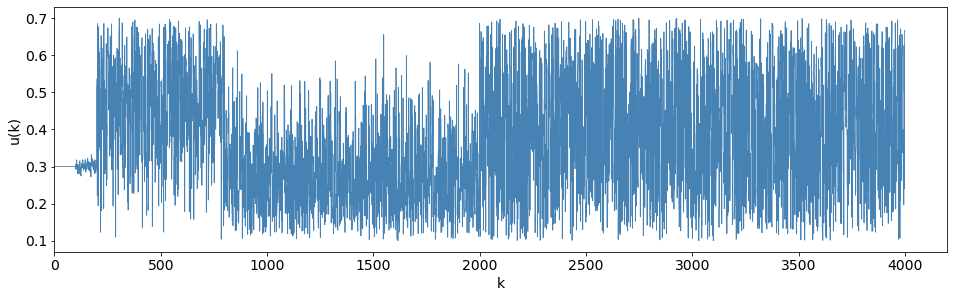

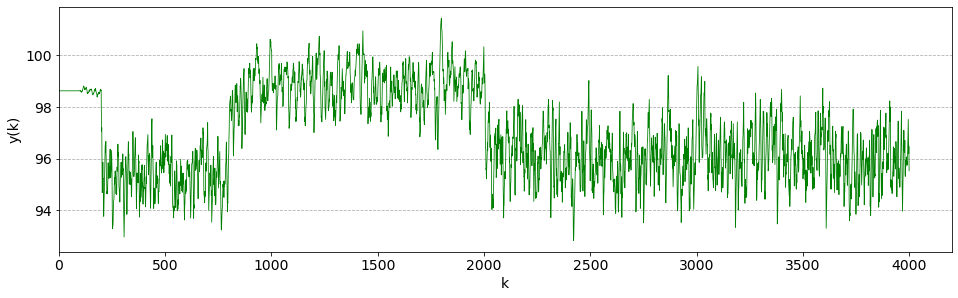

In [3]:
# read data and plot
data = np.loadtxt('exchanger.dat')
u = data[:,1, None]; y = data[:,2, None]

# plots
plt.figure(figsize=(16,4.5))
plt.plot(u, 'steelblue', linewidth=0.8, drawstyle='steps')
plt.ylabel('u(k)'), plt.xlabel('k'), plt.xlim(0)

plt.figure(figsize=(16,4.5))
plt.plot(y, 'g', linewidth=0.8)
plt.ylabel('y(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [4]:
# split into fitting and validation dataset
u_fit = u[:3000,0:1]; u_val = u[3000:,0:1] 
y_fit = y[:3000,0:1]; y_val = y[3000:,0:1] 

In [5]:
# scale data before model fitting
u_scaler = StandardScaler(); u_fit_scaled = u_scaler.fit_transform(u_fit); u_val_scaled = u_scaler.transform(u_val) 
y_scaler = StandardScaler(); y_fit_scaled = y_scaler.fit_transform(y_fit); y_val_scaled = y_scaler.transform(y_val) 

X_fit_scaled = np.hstack((u_fit_scaled, y_fit_scaled)); X_val_scaled = np.hstack((u_val_scaled, y_val_scaled))

In [6]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          re-arrage data with time steps
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# rearrange X data into (# sequence samples, # time steps, # features) form
nTimeSteps = 9
X_fit_scaled_sequence = []; X_val_scaled_sequence = []
y_fit_scaled_sequence = []; y_val_scaled_sequence = []

for sample in range(nTimeSteps, X_fit_scaled.shape[0]):
    X_fit_scaled_sequence.append(X_fit_scaled[sample-nTimeSteps:sample,:])
    y_fit_scaled_sequence.append(y_fit_scaled[sample])
    
for sample in range(nTimeSteps, X_val_scaled.shape[0]):
    X_val_scaled_sequence.append(X_val_scaled[sample-nTimeSteps:sample,:])
    y_val_scaled_sequence.append(y_val_scaled[sample])

# X conversion: convert list of (time steps, features) arrays into (samples, time steps, features) array 
X_fit_scaled_sequence, y_fit_scaled_sequence = np.array(X_fit_scaled_sequence), np.array(y_fit_scaled_sequence) 
X_val_scaled_sequence, y_val_scaled_sequence = np.array(X_val_scaled_sequence), np.array(y_val_scaled_sequence)

In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          fit RNN model
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [8]:
# import Keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

In [9]:
# define model
model = Sequential()
model.add(LSTM(units=6, kernel_regularizer=regularizers.L1(0.001), input_shape=(nTimeSteps,2)))
model.add(Dense(units=1))

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6)                 216       
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 223
Trainable params: 223
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile model
model.compile(loss='mse', optimizer='Adam')

In [11]:
# fit model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_fit_scaled_sequence, y_fit_scaled_sequence, epochs=250, batch_size=125, validation_data=(X_val_scaled_sequence, y_val_scaled_sequence), callbacks=[es])

Epoch 1/250
24/24 [==============================] - 2s 21ms/step - loss: 1.1617 - val_loss: 0.7218
Epoch 2/250
24/24 [==============================] - 0s 5ms/step - loss: 0.8876 - val_loss: 0.5777
Epoch 3/250
24/24 [==============================] - 0s 6ms/step - loss: 0.6642 - val_loss: 0.4669
Epoch 4/250
24/24 [==============================] - 0s 6ms/step - loss: 0.4982 - val_loss: 0.3974
Epoch 5/250
24/24 [==============================] - 0s 5ms/step - loss: 0.3836 - val_loss: 0.3636
Epoch 6/250
24/24 [==============================] - 0s 5ms/step - loss: 0.3101 - val_loss: 0.3437
Epoch 7/250
24/24 [==============================] - 0s 4ms/step - loss: 0.2651 - val_loss: 0.3306
Epoch 8/250
24/24 [==============================] - 0s 4ms/step - loss: 0.2373 - val_loss: 0.3174
Epoch 9/250
24/24 [==============================] - 0s 6ms/step - loss: 0.2184 - val_loss: 0.3023
Epoch 10/250
24/24 [==============================] - 0s 6ms/step - loss: 0.2042 - val_loss: 0.2857
Epoch 11

24/24 [==============================] - 0s 4ms/step - loss: 0.0565 - val_loss: 0.0860
Epoch 84/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0563 - val_loss: 0.0853
Epoch 85/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0561 - val_loss: 0.0855
Epoch 86/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0560 - val_loss: 0.0854
Epoch 87/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0560 - val_loss: 0.0848
Epoch 88/250
24/24 [==============================] - 0s 5ms/step - loss: 0.0557 - val_loss: 0.0853
Epoch 89/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0555 - val_loss: 0.0851
Epoch 90/250
24/24 [==============================] - 0s 5ms/step - loss: 0.0553 - val_loss: 0.0841
Epoch 91/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0554 - val_loss: 0.0842
Epoch 92/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0551 - val_loss: 0.0845
Epoch 93/250


24/24 [==============================] - 0s 4ms/step - loss: 0.0477 - val_loss: 0.0743
Epoch 165/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0478 - val_loss: 0.0748
Epoch 166/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0477 - val_loss: 0.0741
Epoch 167/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0477 - val_loss: 0.0741
Epoch 168/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0745
Epoch 169/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0744
Epoch 170/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.0743
Epoch 171/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0741
Epoch 172/250
24/24 [==============================] - 0s 4ms/step - loss: 0.0473 - val_loss: 0.0737


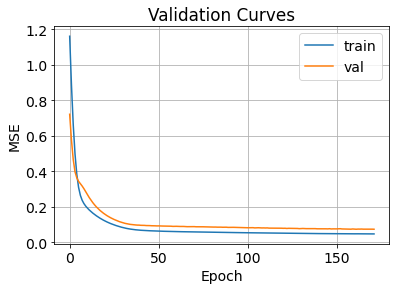

In [12]:
# plot validation curve
plt.figure()
plt.title('Validation Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         Residual analysis on fitting dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

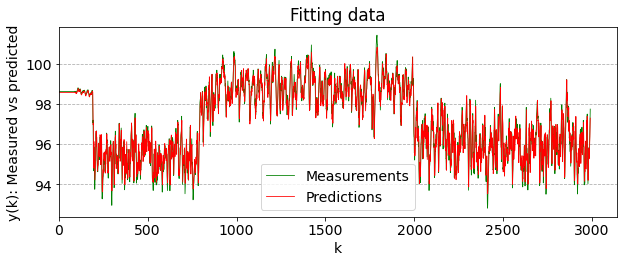

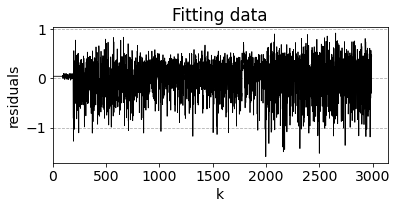

In [13]:
# get model (1-step ahead) predictions and residuals on training dataset
y_fit_scaled_sequence_pred = model.predict(X_fit_scaled_sequence) 
y_fit_sequence_pred =  y_scaler.inverse_transform(y_fit_scaled_sequence_pred)
y_fit_sequence = y_scaler.inverse_transform(y_fit_scaled_sequence)
residuals_fit = y_fit_sequence - y_fit_sequence_pred

plt.figure(figsize=(10,3.5)), plt.plot(y_fit_sequence, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_fit_sequence_pred, 'r', linewidth=0.8, label='Predictions')
plt.title('Fitting data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5)), plt.plot(residuals_fit, 'black', linewidth=0.8)
plt.title('Fitting data'), plt.ylabel('residuals'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

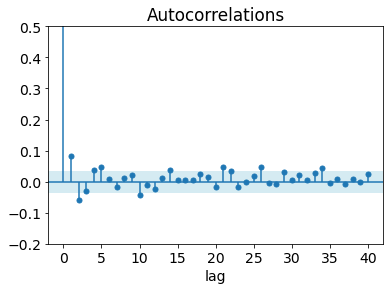

In [14]:
# ACF of residuals
conf_int = 1.96/np.sqrt(len(residuals_fit))

plot_acf(residuals_fit, lags= 40, alpha=None, title='')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xtick labels
plt.xlabel('lag'), plt.title('Autocorrelations'), plt.ylim(-0.2, 0.5) 
plt.show()

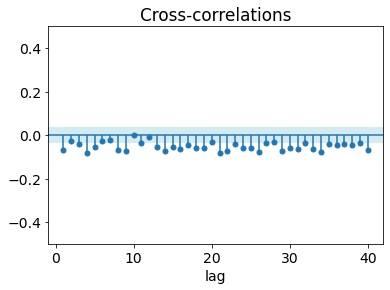

In [15]:
# CCF b/w residuals and input sequence
ccf_vals = ccf(residuals_fit, u_fit, adjusted=False) # ccf for lag > 0
ccf_vals = ccf_vals[1:41] # ccf for lag 1 to 20

# generate CCF plot
lags = np.arange(1,41)

plt.figure(figsize=(6,4)), plt.vlines(lags, [0], ccf_vals), plt.axhline(0, 0, lags[-1])
plt.plot(lags, ccf_vals, marker='o', markersize=5, linestyle='None')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.xlabel('lag'), plt.title('Cross-correlations')
plt.ylim(-0.5, 0.5)
plt.show()

In [10]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##               m-step ahead predictions on validation dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

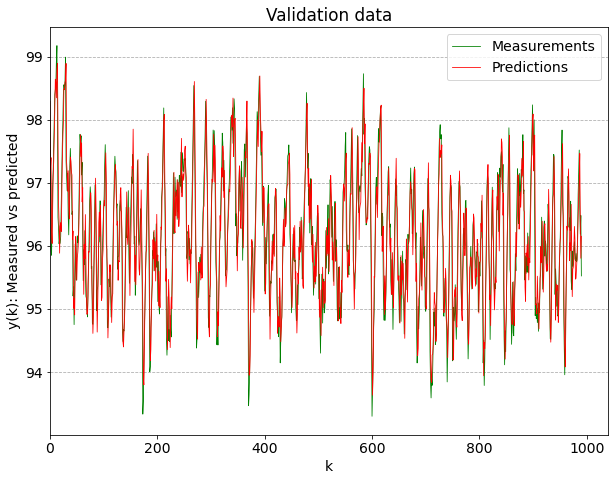

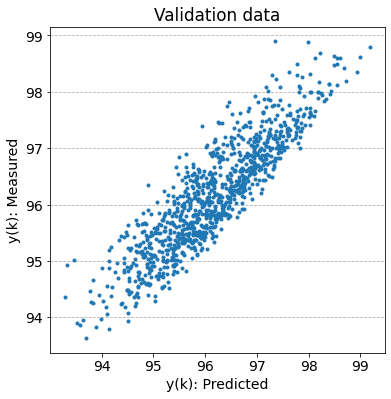

In [16]:
# 1-step ahead predictions
y_val_scaled_sequence_pred = model.predict(X_val_scaled_sequence) 
y_val_sequence_pred =  y_scaler.inverse_transform(y_val_scaled_sequence_pred)
y_val_sequence = y_scaler.inverse_transform(y_val_scaled_sequence)

plt.figure(figsize=(10,7.5)), plt.plot(y_val_sequence, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_val_sequence_pred, 'r', linewidth=0.8, label='Predictions')
plt.title('Validation data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,6)), plt.plot(y_val_sequence, y_val_sequence_pred, '.', linewidth=0.8)
plt.title('Validation data'), plt.ylabel('y(k): Measured'), plt.xlabel('y(k): Predicted')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [17]:
# infinite-step ahead predictions [first nTimeSteps samples are used as initial conditions]
y_val_scaled_sim = np.copy(y_val_scaled)

for sample in range(nTimeSteps, X_val_scaled.shape[0]):
    X_val_scaled_sim = np.hstack((u_val_scaled,y_val_scaled_sim))
    inputSequence = X_val_scaled_sim[sample-nTimeSteps:sample,:]
    inputSequence = inputSequence[None,:,:]
    sim_response = model.predict(inputSequence) 
    y_val_scaled_sim[sample] = sim_response

y_val_pred_sim =  y_scaler.inverse_transform(y_val_scaled_sim)

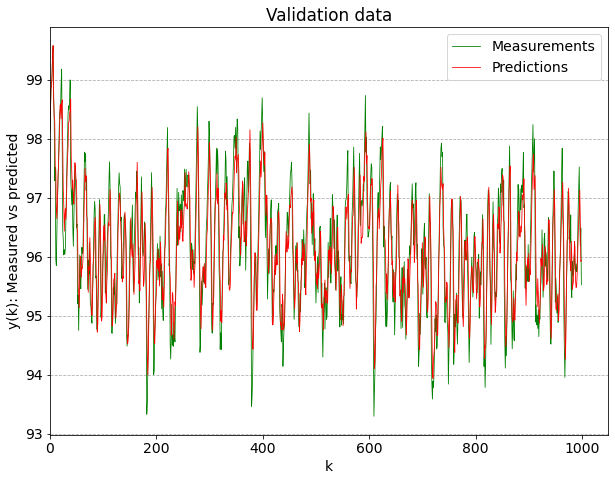

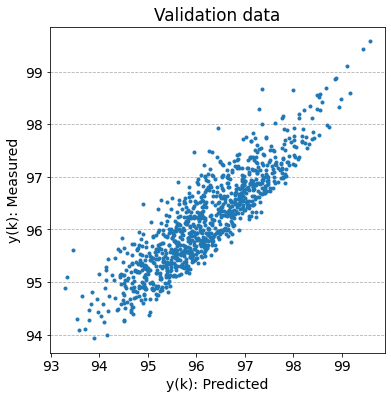

In [18]:
# plot
plt.figure(figsize=(10,7.5)), plt.plot(y_val, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_val_pred_sim, 'r', linewidth=0.8, label='Predictions')
plt.title('Validation data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,6)), plt.plot(y_val, y_val_pred_sim, '.', linewidth=0.8)
plt.title('Validation data'), plt.ylabel('y(k): Measured'), plt.xlabel('y(k): Predicted')
plt.grid(which='both', axis='y', linestyle='--')